In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, recall_score

sns.set()

#color palette
monokai_colors=['#a6e22e','#f92672','#66d9ef','#fd971f','#ae81ff','#e6db74',"#fd5ff0",'#a1efe4','#272828','#75715e']


In [3]:
#balanced dataset
diabetes=pd.read_csv('diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

diabetes_yes=diabetes.drop(index=(diabetes[diabetes['Diabetes_binary']!=1]).index)
diabetes_no=diabetes.drop(index=(diabetes[diabetes['Diabetes_binary']!=0]).index)

# dropping quantiles sup 5% and low 5%
q=diabetes_yes['BMI'].quantile(1-0.05)
diabetes_yes=diabetes_yes[diabetes_yes['BMI']<q]
q=diabetes_yes['BMI'].quantile(0.05)
diabetes_yes=diabetes_yes[diabetes_yes['BMI']>q]

q=diabetes_no['BMI'].quantile(1-0.05)
diabetes_no=diabetes_no[diabetes_no['BMI']<q]
q=diabetes_no['BMI'].quantile(0.05)
diabetes_no=diabetes_no[diabetes_no['BMI']>q]

diabetes_yes=diabetes_yes.reset_index(drop=True)
diabetes_no=diabetes_no.reset_index(drop=False)


df_heat=pd.concat([diabetes_yes,diabetes_no])
df_heat=df_heat.reset_index(drop=True)
df_heat=df_heat.drop(['index'],axis=1)

In [4]:
print(diabetes_yes.shape[0])
print(diabetes_no.shape[0])
print(df_heat.shape[0])
print(diabetes_no.shape[0]+diabetes_yes.shape[0])

31635
31130
62765
62765


In [5]:
#checking multocovariality

df_heat=pd.concat([diabetes_yes,diabetes_no])
df_heat=df_heat.reset_index(drop=True)
df_heat=df_heat.drop(['index'],axis=1)

df_heat=df_heat.rename(columns={'Diabetes_binary':'Diabetes','HighBP':'High blood preassure','HighChol':'High cholesterol',
'HeartDiseaseorAttack':'Heart disease','PhysActivity':'Excercise','Fruits':'Daily fruits','Veggies':'Daily vegetables','HvyAlcoholConsump':'Heavy drinker',
'DiffWalk':'Difficulty walking','AnyHealthcare':'Has insurance','NoDocbcCost':"Can't afford doctor",'GenHlth':'General health',
'MentHlth':'Mental health','PhysHlth':'Physical health','CholCheck':'Had cholesterol checked at least once'})

variables=df_heat.drop(['Diabetes'],axis=1)
vif=pd.DataFrame()
vif['VIF']=[variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif['Features']=variables.columns

print(vif)

          VIF                               Features
0    3.072632                   High blood preassure
1    2.508489                       High cholesterol
2   33.911910  Had cholesterol checked at least once
3   31.490927                                    BMI
4    2.045819                                 Smoker
5    1.165332                                 Stroke
6    1.398607                          Heart disease
7    3.935401                              Excercise
8    2.826439                           Daily fruits
9    5.198811                       Daily vegetables
10   1.065811                          Heavy drinker
11  23.293838                          Has insurance
12   1.220596                    Can't afford doctor
13  13.322766                         General health
14   1.500393                          Mental health
15   2.202130                        Physical health
16   2.043093                     Difficulty walking
17   2.073862                                 

In [6]:
#dropping highly correlated variables
df_heat=df_heat.drop(['Income','Education','Age','General health','Has insurance','Had cholesterol checked at least once','BMI'],axis=1) #no multico

In [7]:
#saving processed df

df_heat.to_csv('diabetes_prepross.csv', index=False)  

In [13]:
#regression models

targets1=df_heat['Diabetes']
inputs1=df_heat.drop(['Diabetes'],axis=1)

#Test train split
X_train, X_test, y_train, y_test=train_test_split(inputs1,targets1,test_size=0.3,random_state=42)

#scale the data
scaler=StandardScaler()
quantile_reg=QuantileTransformer(output_distribution='normal')

X_train_quantile=quantile_reg.fit_transform(X_train)
X_test_quantile=quantile_reg.transform(X_test)

X_train_scaled=scaler.fit_transform(X_train_quantile)
X_test_scaled=scaler.transform(X_test_quantile)

#Gaussian naive Bayes
glf=GaussianNB()
glf.fit(X_train_scaled,y_train)

#Logistic regression
log_reg=LogisticRegression(solver='saga',
C=0.1,warm_start=True,penalty="l2",
fit_intercept=False,
max_iter=10000,random_state=42).fit(X_train_scaled,y_train)
prediction1=log_reg.predict(X_test_scaled)


[0. 1. 0. ... 0. 0. 1.]


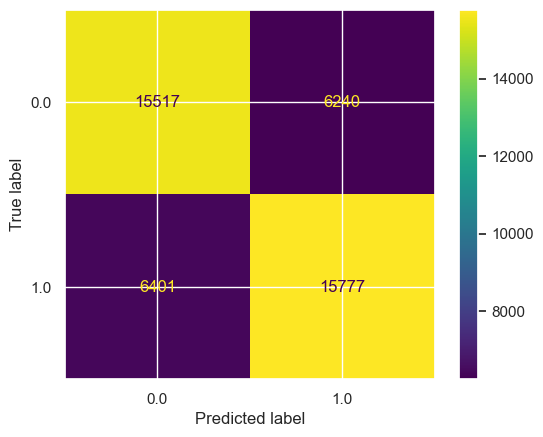

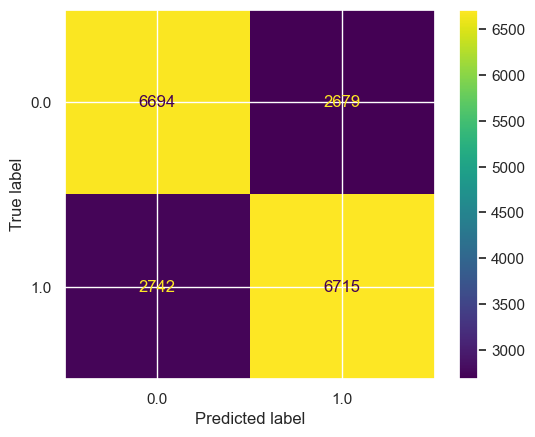

In [9]:
#Evaluating 

#logistic regression confusion matrix
c_matrix1=confusion_matrix(y_train, log_reg.predict(X_train_scaled))
c_matrix2=confusion_matrix(y_test, log_reg.predict(X_test_scaled))

cm_display1=ConfusionMatrixDisplay(confusion_matrix=c_matrix1,display_labels=unique_labels(y_test))
cm_display2=ConfusionMatrixDisplay(confusion_matrix=c_matrix2,display_labels=unique_labels(y_test))
cm_display1.plot()
cm_display2.plot()



In [10]:
print(y_test)
print(log_reg.predict(X_train_scaled))
print(type(log_reg.predict(X_train_scaled)))

12422    1.0
53598    0.0
32778    0.0
13243    1.0
35630    0.0
        ... 
30195    1.0
32748    0.0
32952    0.0
33105    0.0
3602     1.0
Name: Diabetes, Length: 18830, dtype: float64
[0. 0. 0. ... 1. 0. 1.]
<class 'numpy.ndarray'>


[0.4518094  0.62702415 0.22428085 ... 0.08322779 0.14865804 0.57373294]
12422    1.0
53598    0.0
32778    0.0
13243    1.0
35630    0.0
        ... 
30195    1.0
32748    0.0
32952    0.0
33105    0.0
3602     1.0
Name: Diabetes, Length: 18830, dtype: float64
0.5
0.7817407391416883
0.7602786892094345


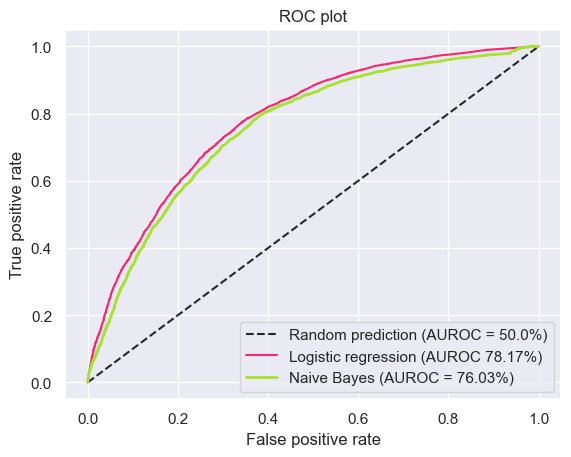

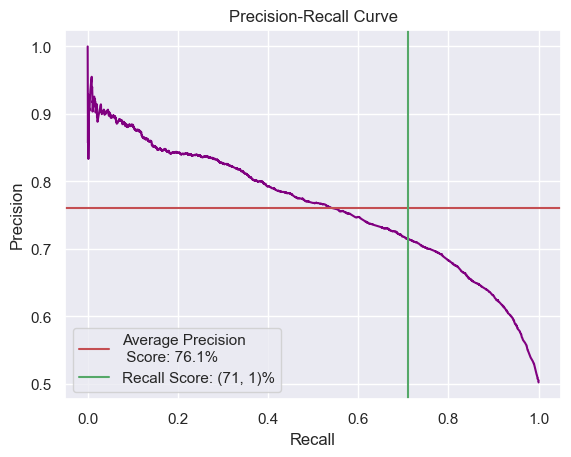

In [14]:
####### PLOT ROC
r_probs=[0 for _ in range(len(y_test))]
log_reg_probs=log_reg.predict_proba(X_test_scaled)
glf_probs=glf.predict_proba(X_test_scaled)

#keeping positives probs
log_reg_probs=log_reg_probs[:,1]
print(log_reg_probs)
print(y_test)
glf_probs=glf_probs[:,1]

#calculate the auroc
r_auc=roc_auc_score(y_test,r_probs)
log_reg_auc=roc_auc_score(y_test, log_reg_probs)
glf_auc=roc_auc_score(y_test, glf_probs)

#### printing scores
print(r_auc)
print(log_reg_auc)
print(glf_auc)

#Calculate_roc_curve
r_fpr, r_tpr, _ =roc_curve(y_test, r_probs)
log_reg_auc_fpr, log_reg_auc_tpr,_=roc_curve(y_test, log_reg_probs)
glf_auc_fpr, glf_auc_tpr,_=roc_curve(y_test, glf_probs)

plt.plot(r_fpr,r_tpr,label=f"Random prediction (AUROC = {round(r_auc*100,2)}%)",c=monokai_colors[8],linestyle='--')
plt.plot(log_reg_auc_fpr,log_reg_auc_tpr,label=f"Logistic regression (AUROC {round(log_reg_auc*100,2)}%)",c=monokai_colors[1])
plt.plot(glf_auc_fpr,glf_auc_tpr,label=f"Naive Bayes (AUROC = {round(glf_auc*100,2)}%)",c=monokai_colors[0],linewidth=2)

plt.title('ROC plot')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()

#calculate precision and recall
precision, recall, thresholds=precision_recall_curve(y_test, log_reg_probs)
precision_av_score=average_precision_score(y_test, log_reg_probs)
av_recall_score=recall_score(y_test,prediction1)

fig,ax=plt.subplots()
ax.plot(recall, precision, color='purple')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.axhline(y = precision_av_score, color = 'r', linestyle = '-',label=f'Average Precision\n Score: {round(precision_av_score*100,1)}%')
ax.axvline(av_recall_score,color='g',label=f'Recall Score: {round(av_recall_score*100),1}%')

ax.legend()
